# Proyección de Estructuras Minimizadas
***
<div style='background-color: #F9E5AB; padding: 5px 12px; font-size: 1.2em;'>Notebook para la visualización de las estructuras minimizadas de la proteína CDK2 a partir de las estructuras cristalográficas.</div>

Los pasos llevados a cabo en este notebook son los siguientes:
1. Se cargan las estructuras de la proteína que resultaron tras el proceso de minimización de la energía potencial con Amber.
- Se crea una trayectoria (o ensamble) con éstas estructuras (**traj_minimized**). Para ello se emplea `pytraj`.
- Se carga el objeto con la información del **cMDS de las estructuras cristalográficas**. Este objeto fue previamente generado en otro notebook.
- Se carga el **ensamble con las 402 estructuras cristalográficas**, el cual servirá para calcular el RMSD de las estructuras minimizadas frente a las cristalográficas, con la intención de generar la matriz de RMSD suplementaria que permitirá hacer la proyección de las nuevas conformaciones (las minimizadas) en el espacio definido por las conformaciones cristalográficas.
- Se hace la proyección de las nuevas conformaciones.
- Visualizamos el resultado.

    
Carga de las librerías necesarias:

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import pytraj as pyt
sys.path.append(r'..')

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
prot_name = 'cdk2'
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_string = '../data/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json'.split('/')
path_to_json_file = glob.glob((os.path.join(*path_string)))[0]
                      
df_prot = pd.read_json(path_to_json_file)

### Carga de las estructuras Minimizadas

In [3]:
# Carga de la trayectoria de estructuras cristalograficas
path_min_directory = '../../ARCHIVOS/CRISTALES/PROT_CDK2_PREPARADAS/MIN/MIN_OUTS'.split('/')
files_pdb_min_struc = glob.glob(os.path.join(*path_min_directory) + '/*pdb')
# Ordenamso la lista de archivos
files_pdb_min_struc.sort()

Cargamos la lista de los residuos usados por Pisani, *et al.* (2016).

In [4]:
from modules.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",")
mask_pisani = ':' + pisiani_residues + '@CA'

Cargamos las estructuras minimizadas y generamos una trayectoria con ellas seleccionando únicamnete los átomos *CA* (carbonos alfa) de los residuos de Pisani.

In [5]:
import pytraj as pyt
_itraj_minimized = pyt.iterload(files_pdb_min_struc, top = files_pdb_min_struc[0])

# Selección de los lso carbonos alfa de los residuos de Pisani
traj_minimized = _itraj_minimized[mask_pisani]
traj_minimized

pytraj.Trajectory, 402 frames: 
Size: 0.001051 (GB)
<Topology: 117 atoms, 117 residues, 117 mols, PBC with box type = truncoct>
           

### Carga de la trayectoria de Referencia (Cristalográfica)
Cargamos el ensamble de estructuras cristalográficas.

In [6]:
path_to_crystal_traj = '../../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/PDB_402_cdk2_PISANI_ALL.pdb'.split('/')
file_pdb_traj_pisani = os.path.join(*path_to_crystal_traj)
# Por ahora cargamos tods los átomos, sumiendo que en algun momento necesitaremos todos los átomos
traj_crystals = pyt.load(file_pdb_traj_pisani)
traj_crystals = traj_crystals.superpose()[mask_pisani]
traj_crystals

pytraj.Trajectory, 402 frames: 
Size: 0.001051 (GB)
<Topology: 117 atoms, 117 residues, 117 mols, non-PBC>
           

### Carga del cMDS con las estructuras Cristalogŕaficas

In [7]:
# Carga del objeto cMDS de las 402 estructuras cristalográficas
import pickle
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
#
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

### Proyección de las estructuras minimizadas en el espacio 

Usamos la función `get_sup_points_projected_mds` que previemente habíamos definido, por ahora se ha guardado el archivo con esta  función en el mismo directorio de este notebook. 

In [8]:
from modules.MDS import cMDS_proj
from miscellanious_traj_functions import get_sup_points_projected_mds

In [9]:
help(get_sup_points_projected_mds)

Help on function get_sup_points_projected_mds in module miscellanious_traj_functions:

get_sup_points_projected_mds(MDS_ref_object, traj_reference, traj_out_of_sample, ref=0, n_components=2)
    Obtain the D-suplementary RMSD matrix of a suplementary trajectory and 
    perfroms cMDS projection of out of sample points by using get_sup_rmsd_pairwise() function.
    
    Parameters:
        MDS_ref_object (MDS object): cMDS object.
        traj_reference (pytraj.trajectory): pytraj Trajectory object with m frames and sliced atoms
        traj_out_of_sample: pytraj Trajectory object with n frames sliced atoms
        ref (int):  number of conformations inside traj_reference to use 
                    as reference to superpose traj_out_of_sample
        n_vects (int): Number of mds eigenvectors to return
    Returs:
        mds_projected (numpy narray): n_vects mds eigenvectors



In [10]:
projected_points = get_sup_points_projected_mds(MDS_ref_object = mds_pisani_402,
                             traj_reference = traj_crystals,
                             traj_out_of_sample = traj_minimized)

## Visualización

Finalmente, visualizamos la proyección de las estructuras cristalográficas a la par de las nuevas conformaciones proyectadas.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', style = 'white')
from modules.plotting_functions import plot_points, plot_anotation_labels

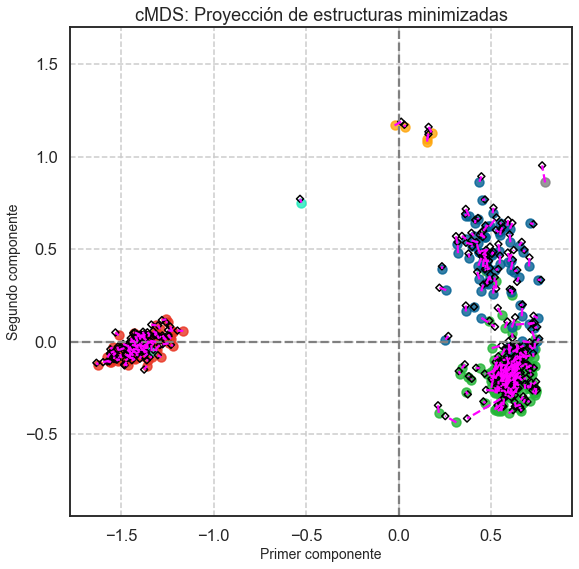

In [12]:
# Se genera la gráfica de ejmplo de proyección
fig = plt.figure(figsize=(9, 9))
plot_points(mds = mds_pisani_402[0], labels = df_prot.Labels_conf, alpha=0.8,
                             title = "cMDS: Proyección de estructuras minimizadas", point_size = 80,
           )
# Proyección de los puntos "out of sample"
plt.scatter(projected_points[0], projected_points[1], marker = 'D', 
            c = 'None', edgecolors='black', s = 25);

n_confs = traj_crystals.n_frames
for i in range(n_confs):
    plt.plot([mds_pisani_402[0][0][i], projected_points[0][i]],
             [mds_pisani_402[0][1][i], projected_points[1][i]],  'r--', c='magenta')


<div style='background-color: #F5A566; padding: 5px 12px;'>Al final del notebook se muestra una visualización interactiva de esta proyección.</div>

## Visualización interactiva con Bokeh

In [13]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ResetTool, PanTool, WheelZoomTool, ColumnDataSource, \
Span, HoverTool, LabelSet, Range1d, Title
from bokeh.transform import factor_cmap
from bokeh.models import OpenURL, TapTool
output_notebook()

Loading BokehJS ...

In [14]:
HOVER = HoverTool(names=["ref"])
TOOLTIPS = [
    ("index", "$index"),
    ("PDB ID", "@pdb_id"),
    ("conf", "@conf_label")]
TOOLS = ['pan', 'wheel_zoom', HOVER, ResetTool(), 'tap']

f = figure(plot_width = 900, plot_height = 900,
          title = 'Proyección de estructuras minimizadas',
          match_aspect = True, active_scroll = 'wheel_zoom',
          tooltips = TOOLTIPS, tools = TOOLS)

# Styling del plot
f.title.text_font_size = '2em'
f.add_layout(Title(text="Usar el mouse para interactuar: Moverse, Acercar/alejar y"+ \
                   "'click' para interactuar con los puntos"), 'above')

# Axis
f.axis.axis_line_width = 3.3
f.axis.major_label_text_font_size = '1.1em'
f.axis.major_label_text_font_style = 'bold'

# Labels
f.axis.axis_label_text_font_size = '1.4em'
f.xaxis.axis_label = 'Dimensión 1'
f.yaxis.axis_label = 'Dimensión 2'

# Vertical line
vline = Span(location=0, dimension='height', 
             line_color='grey', line_width=2, line_dash='dashed')
# Horizontal line
hline = Span(location=0, dimension='width', 
             line_color='grey', line_width=2, line_dash='dashed')
f.renderers.extend([vline, hline])

CONFS = df_prot.Labels_conf.unique()
colors_list = [ '#036193', '#23B537', '#E93523', 'gray',   '#FEA50A','#23E9BC']
confs_cmap = factor_cmap('conf_label', colors_list, CONFS)

# DataSource de Estructuras  Cristalográficas
source_ref = ColumnDataSource(data = {
    'x': mds_pisani_402[0][0],
    'y': mds_pisani_402[0][1],
    'pdb_id': df_prot.index.to_series().apply(lambda x: x.upper()),
    'conf_label': df_prot.Labels_conf
})

source_proj = ColumnDataSource(data = {
    'x': projected_points[0],
    'y': projected_points[1],
    'conf_label': df_prot.Labels_conf
})

n_confs = traj_crystals.n_frames
for i in range(n_confs):
    f.line(x = [mds_pisani_402[0][0][i], projected_points[0][i]],
           y = [mds_pisani_402[0][1][i], projected_points[1][i]],
           color = 'black')

f.scatter('x', 'y', source = source_ref, name = 'ref',
          size = 10, alpha = 0.9, color = confs_cmap, 
          line_color = '#111111', legend = 'Estructuras Cristalográficas')

f.scatter('x', 'y', source = source_proj, name = 'proj', 
          color = confs_cmap, marker = "diamond", size = 10, alpha = 0.8,
          legend = 'Estructuras Minimizadas', muted_alpha = 0.1)

f.legend.click_policy = 'mute'
f.legend.location = 'top_left'
f.x_range = Range1d(-1.8, 1, bounds = (-2.0, 1.2))
f.y_range = Range1d(-1.0, 1.5, bounds= (-1.2, 1.7))
f.toolbar_location = 'above'
f.toolbar.logo = None
### URL
url = 'https://www.rcsb.org/structure/@pdb_id'
taptool = f.select(type = TapTool)
taptool.callback = OpenURL(url = url)
show(f)